In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

## Preparation

### Load packages

In [2]:
#!sudo apt-get install -y xvfb ffmpeg
#!pip install 'gym==0.10.11'
#!pip install 'imageio==2.4.0'
#!pip install PILLOW
#!pip install 'pyglet==1.3.2'
#!pip install pyvirtualdisplay
#!pip install tf-agents

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

### Hyperparameters

In [4]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites.

Python environments have a `step(action) -> next_time_step` method that applies an action to the environment, and returns the following information about the next step:
1. `observation`: This is the part of the environment state that the agent can observe to choose its actions at the next step.
2. `reward`: The agent is learning to maximize the sum of these rewards across multiple steps.
3. `step_type`: Interactions with the environment are usually part of a sequence/episode. e.g. multiple moves in a game of chess. step_type can be either `FIRST`, `MID` or `LAST` to indicate whether this time step is the first, intermediate or last step in a sequence.
4. `discount`: This is a float representing how much to weight the reward at the next time step relative to the reward at the current time step.

These are grouped into a named tuple `TimeStep(step_type, reward, discount, observation)`.

The interface that all python environments must implement is in `environments/py_environment.PyEnvironment`. The main methods are:

### The Simple Environment for Covid Papers

Description:
- The academia is accecpting covid-19 papers in order to maximize the total citations. Each paper has an expected number of citations.

An environment that represents the game could look like this:
1. Actions: We have N actions, that is, accepting 1 paper from all N papers.
2. Observations: The papers not published.
3. Reward: The objective is maximize the total citations, so we can achieve this using the following reward at the end of the round:
  Number of citations of the paper if the paper is not published, else 0

In [67]:
import pandas
import copy
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.specs import BoundedArraySpec
from tf_agents.specs import array_spec
from tf_agents.trajectories.time_step import StepType
from tf_agents.trajectories.time_step import TimeStep


class CovidPaperSimpleEnv(py_environment.PyEnvironment):
    
    def __init__(self, discount=1.0):
        """Initializes CovidPaperSimpleEnv.

            Args:
                discount: Discount for reward.
        """
        print("Init environment ...")
        super(CovidPaperSimpleEnv, self).__init__()
        self.DATA = pandas.read_csv("../data/rl_demo_data.csv")
        self.NUM_OF_PAPERS = self.DATA.shape[0]
        self.REWARD_ILLEGAL_MOVE = np.asarray(-10., dtype=np.float32) # Illegal publish, i.e. republish
        self.Counter = 0
        
        self._discount = np.asarray(discount, dtype=np.float32)
        self._states = None
        self._action_spec = array_spec.BoundedArraySpec((), np.int32, minimum=0, maximum=self.NUM_OF_PAPERS-1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec((self.NUM_OF_PAPERS,), np.int32, minimum=0, maximum=1, name='observation')

    def action_spec(self):
        """Assign the rows of data, that are papers, as possible actions
        """
        return self._action_spec

    def observation_spec(self):
        """The publishing status of papers as observation
        """
        return self._observation_spec

    def _reset(self):
        self._states = np.zeros((self.NUM_OF_PAPERS,), np.int32)
        return TimeStep(StepType.FIRST, np.asarray(0.0, dtype=np.float32), self._discount, self._states)

    def get_state(self) -> TimeStep:
        # Returning an unmodifiable copy of the state.
        return copy.deepcopy(self._current_time_step)

    def set_state(self, time_step: TimeStep):
        self._current_time_step = time_step
        self._states = time_step.observation

    def _step(self, action: np.ndarray):
        """Define step. Cases: last, illegal, middle ones(update if next state is last).
        """
        
        if self._current_time_step.is_last():
            # print("Step: " + str(self.Counter))
            return self._reset()
        
        self.Counter = self.Counter + 1
        
        if self._states[action] != 0:
            return TimeStep(StepType.LAST, self.REWARD_ILLEGAL_MOVE, self._discount, self._states)

        self._states[action] = 1

        is_final, reward = self._check_states(self._states)
        
        step_type = StepType.MID
        if np.all(self._states == 0):
            step_type = StepType.FIRST
        elif is_final:
            step_type = StepType.LAST

        return TimeStep(step_type, reward, self._discount, self._states)

    def _check_states(self, states: np.ndarray):
        """Check if the given states are final and calculate reward.
            Args:
              states: states of the board.

            Returns:
              A tuple of (is_final, reward) where is_final means whether the states
              are final are not, and reward is the reward for stepping into the states
        """
        # Reward: Summation of citations for all published papers
        rewards = np.asarray(np.sum(self.DATA['Cit'].to_numpy().take(np.where(states == 1)[0])), dtype=np.float32)

        if 0 in states:
            return False, rewards
        
        return True, rewards

In [68]:
from tf_agents.environments import utils

env = CovidPaperSimpleEnv()
utils.validate_py_environment(env, episodes=5)

Init environment ...


In [69]:
# train and eval use the same environment
from tf_agents.environments import tf_py_environment

train_env = tf_py_environment.TFPyEnvironment(env)
eval_env = tf_py_environment.TFPyEnvironment(env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)
-   [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290).

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

Use `tf_agents.networks.q_network` to create a `QNetwork`, passing in the `observation_spec`, `action_spec`, and a tuple describing the number and size of the model's hidden layers.

In [70]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [71]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [72]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [73]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [74]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [75]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

5469.2

## Replay Buffer

The replay buffer keeps track of data collected from the environment. This tutorial uses `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.


In [76]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [77]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

In [78]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 348), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.int32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [79]:
iterator = iter(dataset)

print(iterator)


## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [80]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 19827.533203125
step = 400: loss = 80905.7421875
step = 600: loss = 173070.59375
step = 800: loss = 568271.8125
step = 1000: loss = 172214.765625
step = 1000: Average Return = 16.0
step = 1200: loss = 1455545.0
step = 1400: loss = 2601164.5
step = 1600: loss = 1691220.375
step = 1800: loss = 2689059.5
step = 2000: loss = 7292276.0
step = 2000: Average Return = 16.0
step = 2200: loss = 15636450.0
step = 2400: loss = 10139023.0
step = 2600: loss = 50049744.0
step = 2800: loss = 1464943.5
step = 3000: loss = 39674640.0
step = 3000: Average Return = 16.0
step = 3200: loss = 2368655.0
step = 3400: loss = 63558060.0
step = 3600: loss = 24347168.0
step = 3800: loss = 72446336.0
step = 4000: loss = 1613992.75
step = 4000: Average Return = 16.0
step = 4200: loss = 5826146.5
step = 4400: loss = 75772368.0
step = 4600: loss = 43258832.0
step = 4800: loss = 3002481.5
step = 5000: loss = 153190064.0
step = 5000: Average Return = 16.0
step = 5200: loss = 66679328.0
step = 5400: lo

## Visualization
### Plots
Use `matplotlib.pyplot` to chart how the policy improved during training.

(13.95, 250.0)

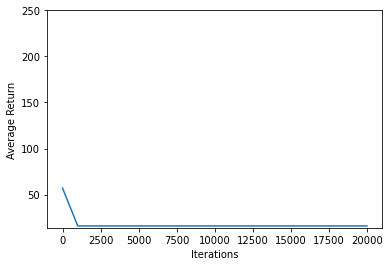

In [81]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)